# Bayesian Optimization

[Bayesian Optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) is used to solve an optimization problem
$$ x^* = \text{argmin} \ f(x), $$
where $f$ is an unknown objective function which
+ hard to compute,
+ has no derivative,
+ observations of $f$ contain noise.

An optimization process includes constructing a sequence of points $\{x_n\}$ which converges to $x^*$. However, due to the above restrictions, it is hard to construct such sequence using information directly from $f$. In Bayesian Optimization, we put a [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) prior on $f$ and derive from it an "acquisition" function $\alpha(x)$ which is easy to evaluate and get derivatives (hence optimizing $\alpha(x)$ is easy). This "acquisition" function encodes the following information for $f$: its minimizer is a candidate for $x_n$.

Each time we get more information from $f$, the Gaussian Process model will be updated (similar to the way we update posteriors in Bayesian models) and the derived "acquisition" function will reflect more information about $x^*$. After a number of steps, it is likely that $\{x_n\}$ will converge to the minimizer of $f$.

In this tutorial, we will see how to use the Gaussian Process module in Pyro to do Bayesian Optimization.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import constraints, transform_to

from pyro.contrib.gp.kernels import Matern52
from pyro.contrib.gp.models import GPRegression
from pyro.optim import Adam

## Define a problem

The objective function we are going to solve is
$$f(x) = \frac{x^2}{10} + \sin(x), \quad x\in [-10, 10].$$

In [2]:
def f(x):
    return x**2 / 10 + torch.sin(x)

The minimizer of $f$ is $-1.30644$. Let's take a plot for $x$.

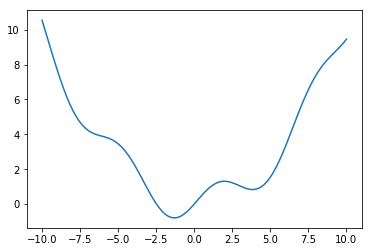

In [3]:
x = torch.linspace(-10, 10)
plt.plot(x.numpy(), f(x).numpy());

## Learning

### Define an acquisition function

In [4]:
class LowerConfidenceBound(nn.Module):
    def __init__(self, model, x0, constraint=None):
        super(LowerConfidenceBound, self).__init__()
        self.model = model
        self.x0 = x0
        self.constraint = constraint

    def update_data(self, x, objective):
        y = objective(x)
        X = torch.cat([self.model.X, x])
        y = torch.cat([self.model.y, y])
        self.model.set_data(X, y)
        self.model.optimize(optimizer=Adam({}))

    def minimizer(self):
        if self.constraint is not None:
            unconstrained_x0 = transform_to(self.constraint).inv(self.x0)
        else:
            unconstrained_x0 = self.x0
        unconstrained_x = torch.tensor(unconstrained_x0, requires_grad=True)
        optimizer = optim.LBFGS([unconstrained_x], lr=1)
        def closure():
            optimizer.zero_grad()
            if self.constraint is not None:
                x = transform_to(self.constraint)(unconstrained_x)
            else:
                x = unconstrained_x
            y = self(x)
            y.backward()
            return y
        optimizer.step(closure)
        if self.constraint is not None:
            x = transform_to(self.constraint)(unconstrained_x)
        else:
            x = unconstrained_x
        return x.detach()

    def forward(self, x):
        loc, var = self.model(x, full_cov=False, noiseless=False)
        sd = var.sqrt()
        return loc - 2 * sd

In [5]:
X = torch.linspace(-10, 10, 5)
y = f(X)
gpmodel = GPRegression(X, y, Matern52(1), torch.Tensor([0.01]))
gpmodel.fix_param("noise")
constraint = constraints.interval(-10, 10)
acquisition = LowerConfidenceBound(gpmodel, x0=torch.tensor([5]), constraint=constraint)

### Make a plot function

In [6]:
def plot(acquisition, xmin):
    Xnew = torch.linspace(-10, 10)
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.plot(acquisition.model.X.numpy(), acquisition.model.y.numpy(), "kx")
    with torch.no_grad():
        loc, var = acquisition.model(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        plt.plot(Xnew.numpy(), loc.numpy(), "r", lw=2)
        plt.fill_between(Xnew.numpy(), loc.numpy() - 2*sd.numpy(), loc.numpy() + 2*sd.numpy(),
                         color="C0", alpha=0.3)
    plt.xlim(-10, 10)
    plt.ylabel("Gaussian Process Regression")

    plt.subplot(2, 1, 2)
    with torch.no_grad():
        plt.plot(Xnew.numpy(), acquisition(Xnew).numpy())
        plt.plot(xmin.numpy(), acquisition(xmin).numpy(), "^", markersize=10,
                 label="minimizer={:.5f}".format(xmin.item()))
    plt.xlim(-10, 10)
    plt.ylabel("Lower Confidence Bound")
    plt.legend()
    plt.show()

### Find x1

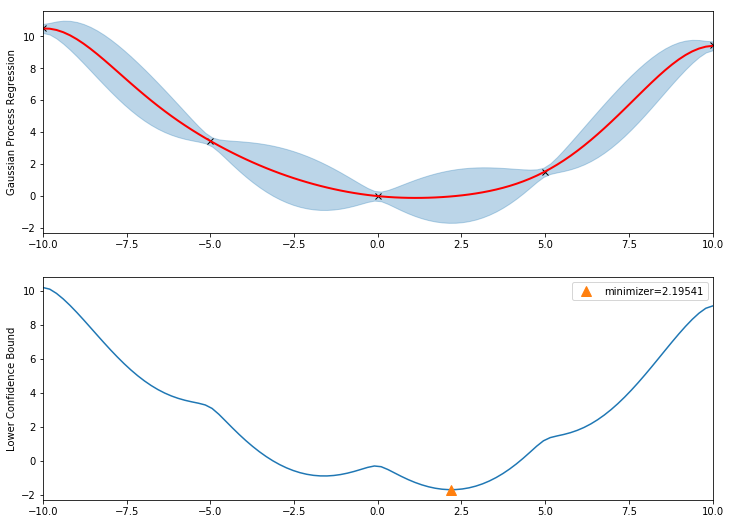

In [7]:
acquisition.model.optimize(Adam({}))
x1 = acquisition.minimizer()
plot(acquisition, x1)

### Find x2

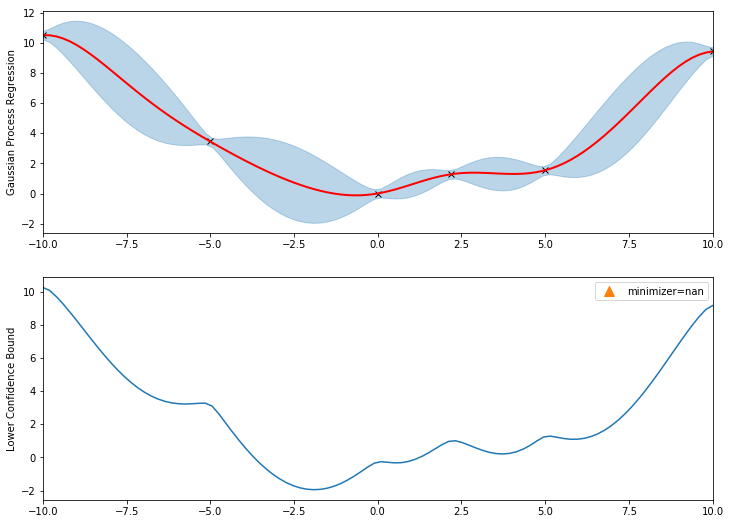

In [8]:
acquisition.update_data(x1, objective=f)
x2 = acquisition.minimizer()
plot(acquisition, x2)